<a href="https://colab.research.google.com/github/NR55/StockPredictorUsingStacking/blob/main/Working_Lag_1_FML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.9/36.9 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 5.6 MB/s eta 0:00:00


In [2]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.8 MB/s eta 0:00:00


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import AutoARIMA
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.compose import StackingForecaster
from sklearn.linear_model import LinearRegression
from sktime.forecasting.trend import STLForecaster
from sktime.forecasting.ets import AutoETS

In [61]:
# Fetch stock data
def fetch_stock_data(ticker, start, end):
    stock = yf.download(ticker, start=start, end=end)
    stock = stock.asfreq('D').ffill()
    return stock

# Load data
ticker = "AAPL"  # Change this to your preferred stock symbol
start_date = "2022-01-01"
end_date = "2024-01-01"
data = fetch_stock_data(ticker, start_date, end_date)

features = ["Open", "High", "Low", "Volume", "Close"]

[*********************100%***********************]  1 of 1 completed


In [62]:
num_days = 14

In [63]:
# Create the 7th lag for all feature columns
for col in features:
      data[f"lag_{col}_{i+1}"] = data[col].shift(i+1)

# data["SMA_7"] = data["Close"].shift(1).rolling(window=7, min_periods=1).mean()
# data["SMA_21"] = data["Close"].shift(1).rolling(window=21, min_periods=1).mean()

# Add current day's Open price as an additional feature
data["Open_today"] = data["Open"]

# Drop NaN values caused by shifting
data.dropna(inplace=True)

# Define target as the current day's Close price
target = data["Close"]

exog_cols = ["Open_today"]
# exog_cols.append("SMA_7", "SMA_21")
exog = data[exog_cols]

for col in features:
  for i in range(3):
      exog[f"lag_{col}_{i+1}"] = data[f"lag_{col}_{i+1}"]

# Split data into train and test sets
y_train, y_test, X_train, X_test = temporal_train_test_split(y=target, X=exog, test_size=0.2)


<ipython-input-63-aef1be2941e5>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog[f"lag_{col}_{i+1}"] = data[f"lag_{col}_{i+1}"]
<ipython-input-63-aef1be2941e5>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog[f"lag_{col}_{i+1}"] = data[f"lag_{col}_{i+1}"]
<ipython-input-63-aef1be2941e5>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [64]:
pd.concat([exog, target], axis=1)

,"(Open_today, )","(lag_Open_1, )","(lag_Open_2, )","(lag_Open_3, )","(lag_High_1, )","(lag_High_2, )","(lag_High_3, )","(lag_Low_1, )","(lag_Low_2, )","(lag_Low_3, )","(lag_Volume_1, )","(lag_Volume_2, )","(lag_Volume_3, )","(lag_Close_1, )","(lag_Close_2, )","(lag_Close_3, )",AAPL
Date,,,,,,,,,,,,,,,,,
2023-01-06,124.561717,125.668857,125.431607,128.782649,126.301500,127.181268,129.395518,123.326101,123.642412,122.742873,80962700.0,89113600.0,112117500.0,123.583107,124.907700,123.632530,128.130219
2023-01-07,124.561717,124.561717,125.668857,125.431607,128.792516,126.301500,127.181268,123.454587,123.326101,123.642412,87754700.0,80962700.0,89113600.0,128.130219,123.583107,124.907700,128.130219
2023-01-08,124.561717,124.561717,124.561717,125.668857,128.792516,128.792516,126.301500,123.454587,123.454587,123.326101,87754700.0,87754700.0,80962700.0,128.130219,128.130219,123.583107,128.130219
2023-01-09,128.970474,124.561717,124.561717,124.561717,128.792516,128.792516,128.792516,123.454587,123.454587,123.454587,87754700.0,87754700.0,87754700.0,128.130219,128.130219,128.130219,128.654144
2023-01-10,128.762863,128.970474,124.561717,124.561717,131.876686,128.792516,128.792516,128.397138,123.454587,123.454587,70790800.0,87754700.0,87754700.0,128.654144,128.130219,128.130219,129.227463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,194.015153,194.015153,194.015153,194.015153,194.243791,194.243791,194.243791,191.818350,191.818350,191.818350,37122800.0,37122800.0,37122800.0,192.444595,192.444595,192.444595,192.444595
2023-12-26,192.454528,194.015153,194.015153,194.015153,194.243791,194.243791,194.243791,191.818350,191.818350,191.818350,37122800.0,37122800.0,37122800.0,192.444595,192.444595,192.444595,191.897873
2023-12-27,191.341219,192.454528,194.015153,194.015153,192.732856,194.243791,194.243791,191.679185,191.818350,191.818350,28919300.0,37122800.0,37122800.0,191.897873,192.444595,192.444595,191.997269


In [65]:
base_models = [
    ('1', AutoARIMA(sp=7, suppress_warnings=True)),
    ('2', make_reduction(KNeighborsRegressor(3), window_length=30, strategy="recursive")),
    ('3', STLForecaster(sp=7)),
    ('4', AutoETS(auto=True))
]

# Define meta-model
meta_model = LinearRegression()

# Create stacking ensemble
model = StackingForecaster(base_models,meta_model)
fh = np.arange(1, num_days+1)
model.fit(y_train, X_train, fh)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

StackingForecaster(forecasters=[('1', AutoARIMA(sp=7, suppress_warnings=True)),
                                ('2',
                                 RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(n_neighbors=3),
                                                                      window_length=30)),
                                ('3', STLForecaster(sp=7)),
                                ('4', AutoETS(auto=True))],
                   regressor=LinearRegression())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Mean Absolute Percentage Error (MAPE): 1.37


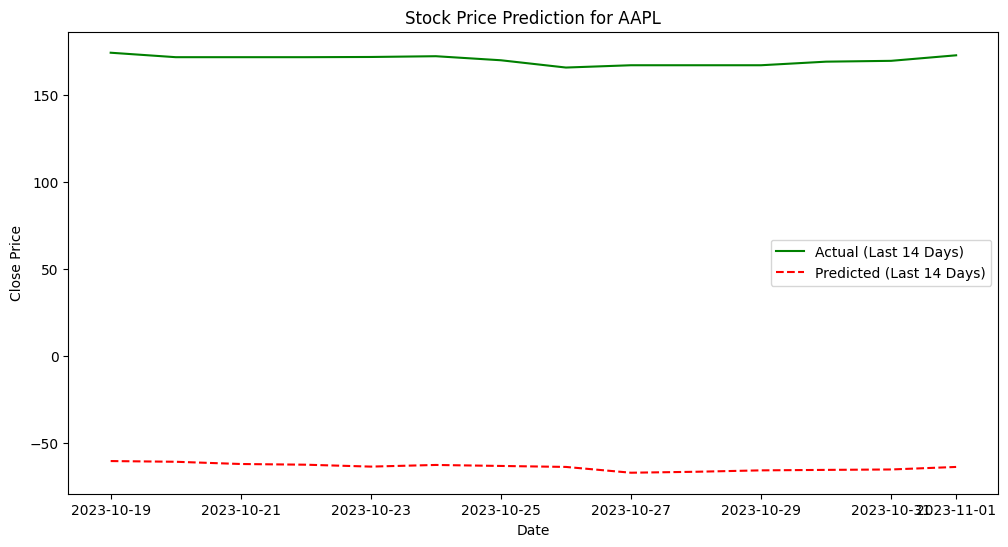

In [66]:
# Forecast
y_pred = model.predict(fh, X_test[:num_days])

# Evaluate
mape = mean_absolute_percentage_error(y_test[:num_days], y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")

pred_ind = y_test[:num_days].index  # Indices for predictions
actual_last_days = y_test[:num_days]  # Actual values for the last num_days

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(actual_last_days.index, actual_last_days, label=f"Actual (Last {num_days} Days)", color="green")
plt.plot(pred_ind, y_pred, label=f"Predicted (Last {num_days} Days)", color="red", linestyle="dashed")

plt.legend()
plt.title(f"Stock Price Prediction for {ticker}")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


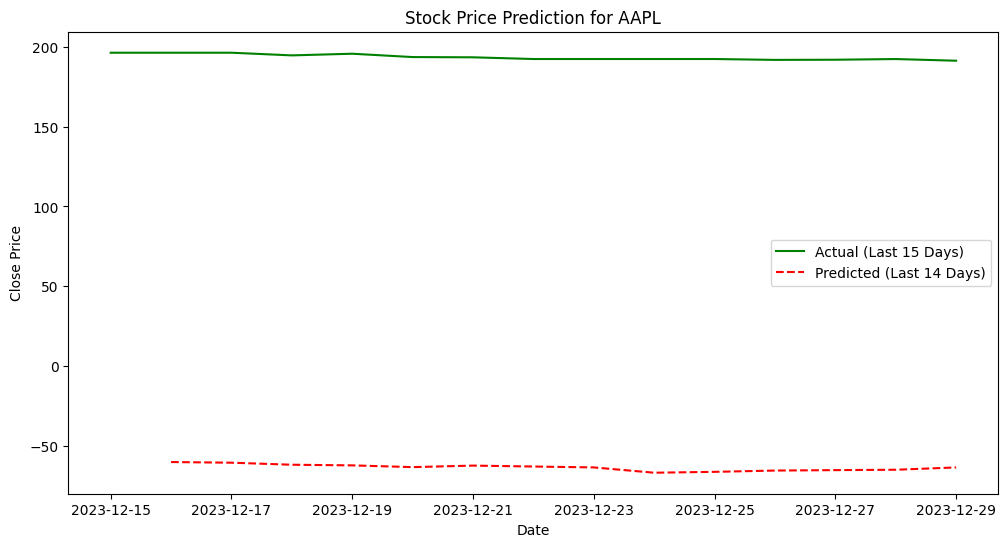

In [67]:
# Get the index of the extra day before num_days
start_idx = max(0, len(y_test) - num_days - 1)  # One day before num_days

# Adjust actual values and indices
extended_actual = y_test[start_idx:len(y_test)]  # Include one extra day before
extended_pred_ind = y_test[start_idx+1:len(y_test)].index  # Predictions from num_days

# Adjust predicted values (should match the last num_days)
y_pred_adjusted = y_pred[-num_days:]  # Ensure same shape as actual last num_days

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(extended_actual.index, extended_actual, label=f"Actual (Last {num_days+1} Days)", color="green")
plt.plot(extended_pred_ind, y_pred_adjusted, label=f"Predicted (Last {num_days} Days)", color="red", linestyle="dashed")

plt.legend()
plt.title(f"Stock Price Prediction for {ticker}")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


In [45]:
# # Forecast

# y_pred = model.predict(fh, X_test[:7])

# # Evaluate
# mape = mean_absolute_percentage_error(y_test[:7], y_pred)
# print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")

# # Plot results
# pred_ind = y_test[:7].index
# res = target[:7]
# plt.figure(figsize=(12, 6))
# plt.plot(pred_ind, res , label='Actual', color='blue')
# plt.plot(pred_ind, y_pred, label='Predicted', color='red', linestyle='dashed')
# plt.legend()
# plt.title(f"Stock Price Prediction for {ticker}")
# plt.xlabel("Date")
# plt.ylabel("Close Price")
# plt.show()

In [12]:
# model = StackingForecaster(base_models,meta_model)
# fh = np.arange(1, len(y_test) + 1)
# model.fit(y_train, X_train, fh)

In [13]:
# # Forecast

# y_pred = model.predict(fh, X_test)

# # Evaluate
# mape = mean_absolute_percentage_error(y_test[:7], y_pred)
# print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")

# # Plot results
# pred_ind = y_test.index
# plt.figure(figsize=(12, 6))
# plt.plot(data.index,target , label='Actual', color='blue')
# plt.plot(pred_ind, y_pred, label='Predicted', color='red', linestyle='dashed')
# plt.legend()
# plt.title(f"Stock Price Prediction for {ticker}")
# plt.xlabel("Date")
# plt.ylabel("Close Price")
# plt.show()